In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt

# Wczytanie danych
bike_data_raw = pd.read_csv('daily-bike-share.csv')
bike_data_raw['dteday'] = pd.to_datetime(bike_data_raw['dteday'])
bike_data_raw

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364


In [5]:
# Przygotowanie danych
bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis=1, inplace=True)
bike_data['difference_temp'] = (bike_data['atemp'] - bike_data['temp']) / bike_data['temp']
bike_data.drop(['atemp'], axis=1, inplace=True)

numeric_features = ['temp', 'difference_temp', 'hum', 'windspeed']
categorical_features = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
target = 'rentals'

In [6]:
# Podział danych na zbiór treningowy i testowy
X = bike_data[numeric_features + categorical_features].copy()
y = bike_data[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
# Definicja transformatorów dla cech numerycznych i kategorycznych
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Połączenie transformatorów w ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [8]:
# Tworzenie końcowego Pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])


In [9]:
# Definicja parametrów do przeszukania w GridSearchCV
params = {
    'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
    'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
    'regressor__l1_ratio': np.arange(0, 1.1, 0.1)
}


In [11]:
# Przeszukiwanie siatki i trenowanie modelu
cv = KFold(n_splits=5, shuffle=False)
final_polynomial_regression_gridsearch = GridSearchCV(final_pipeline, params, scoring='neg_mean_squared_error', cv=cv, )
final_polynomial_regression_gridsearch.fit(X_train, y_train)

c:\Kodilla\kurs\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.169e+07, tolerance: 2.207e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Kodilla\kurs\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e+07, tolerance: 2.268e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('logtransformer',
                                                                                          PowerTransformer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('polynomialfeatures',
                                                                                          PolynomialFeatures())]),
                                                                         ['temp',
                                                                          'difference_temp',
                                                                          'hum',
                                                                          'windspeed']),
                                                                        ('cat',
                                                                         Pipeline(steps...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['season',
                                                                          'mnth',
                                                                          'holiday',
                                                                          'weekday',
                                                                          'workingday',
                                                                          'weathersit'])])),
                                       ('regressor', ElasticNet())]),
             param_grid={'preprocessor__num__polynomialfeatures__degree': [1, 2,
                                                                           3, 4,
                                                                           5],
                         'regressor__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1,
                                              0.0, 1.0, 10.0, 100.0],
                         'regressor__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_squared_error')

In [12]:
# Najlepsze hiperparametry
print("\nNajlepsze hiperparametry:", final_polynomial_regression_gridsearch.best_params_, "\n")



Najlepsze hiperparametry: {'preprocessor__num__polynomialfeatures__degree': 1, 'regressor__alpha': 0.1, 'regressor__l1_ratio': np.float64(0.4)} 



In [13]:
# Predykcje na zbiorze testowym
final_polynomial_regression_model = final_polynomial_regression_gridsearch.best_estimator_
predictions = final_polynomial_regression_model.predict(X_test)


In [14]:
# Ocena modelu
final_r2_train = r2_score(y_train, final_polynomial_regression_model.predict(X_train))
final_r2_test = r2_score(y_test, predictions)
final_mae_train = mean_absolute_error(y_train, final_polynomial_regression_model.predict(X_train))
final_mae_test = mean_absolute_error(y_test, predictions)
final_mape_train = mean_absolute_percentage_error(y_train, final_polynomial_regression_model.predict(X_train))
final_mape_test = mean_absolute_percentage_error(y_test, predictions)
final_mse_train = mean_squared_error(y_train, final_polynomial_regression_model.predict(X_train))
final_mse_test = mean_squared_error(y_test, predictions)
final_rmse_train = sqrt(final_mse_train)
final_rmse_test = sqrt(final_mse_test)



In [15]:
print(f'Final Model Train R^2: {final_r2_train}')
print(f'Final Model Test R^2: {final_r2_test}')
print(f'Final Model Train MAE: {final_mae_train}')
print(f'Final Model Test MAE: {final_mae_test}')
print(f'Final Model Train MAPE: {final_mape_train}')
print(f'Final Model Test MAPE: {final_mape_test}')
print(f'Final Model Train MSE: {final_mse_train}')
print(f'Final Model Test MSE: {final_mse_test}')
print(f'Final Model Train RMSE: {final_rmse_train}')
print(f'Final Model Test RMSE: {final_rmse_test}')

Final Model Train R^2: 0.7010738030778285
Final Model Test R^2: 0.5246818862090765
Final Model Train MAE: 261.2984273983087
Final Model Test MAE: 348.5851935515566
Final Model Train MAPE: 0.7443187889204681
Final Model Test MAPE: 0.8593319730028233
Final Model Train MSE: 136897.75284013432
Final Model Test MSE: 234195.93113132
Final Model Train RMSE: 369.99696328501716
Final Model Test RMSE: 483.93794140501114


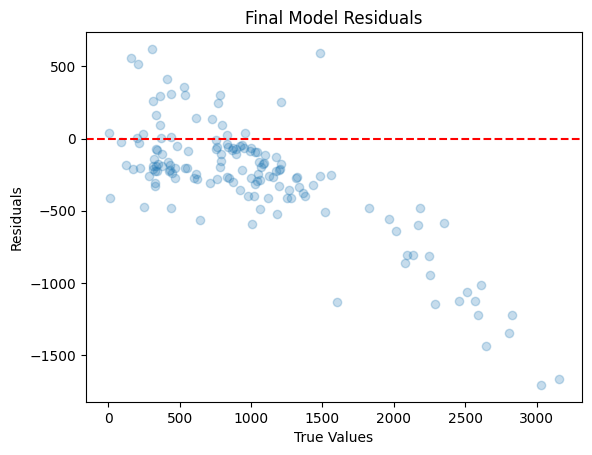

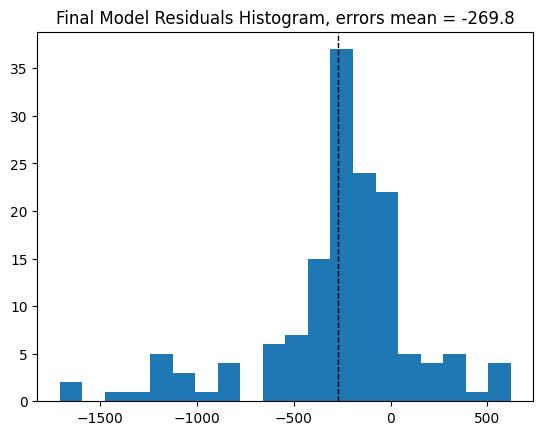

In [16]:
# Wizualizacja reszt
final_errors = predictions - y_test
plt.scatter(x=y_test, y=final_errors, alpha=0.25)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Final Model Residuals')
plt.show()

plt.hist(final_errors, bins=20)
plt.axvline(final_errors.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title(f'Final Model Residuals Histogram, errors mean = {np.round(final_errors.mean(), 2)}')
plt.show()
